In [ ]:
#Elguindy Abdelrahman 21102968/ Georges Martin 28731590
#imports
import numpy as np
import matplotlib.pyplot as plt
import projet_etu
import importlib
importlib.reload(projet_etu)
from projet_etu import Sequentiel, Linear, TanH, Softmax, CrossEntropyLoss, Optim, SGD,MSELoss,Sigmoid,BCE,AutoEncodeur, LogSoftmax, NLLLoss,Conv2D, Flatten,MaxPool2D


### Verifying that the gradients computed by our backpropagation implementation are correct by comparing them to numerical gradients.

In [8]:

np.random.seed(0)
X_sample = np.random.randn(50, 1)  
true_W_val = np.array([[4.0]])    
true_b_val = 2.0                   
y_sample = X_sample @ true_W_val + true_b_val + np.random.randn(X_sample.shape[0], 1) * 0.1 # y based on X_sample
model = Linear(1, 1) 
loss_fn = MSELoss()  
#####################################################################################################################


#  Perform a full forward and backward pass to compute analytical gradients
model.zero_grad() # Ensure gradients are fresh if model was used before
# Forward pass
y_hat_analytical = model.forward(X_sample)
# Compute loss
loss_analytical_values = loss_fn.forward(y_sample, y_hat_analytical)
# Backward pass to get delta from loss
delta_analytical = loss_fn.backward(y_sample, y_hat_analytical)
# Backward pass to update model's internal gradients
model.backward_update_gradient(X_sample, delta_analytical)
# Now, model._gradient contains the analytical gradients
gradients_analytical_dict = model._gradient
epsilon = 1e-5 # Small perturbation value
parameter_dict = model._parameters

#####################################################################################################################

all_checks_passed = True
for param_name, params_array in parameter_dict.items():
    # Iterate over each individual weight/bias element
    it = np.nditer(params_array, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        original_value = params_array[idx]

        # Calculate loss for (parameter + epsilon)
        params_array[idx] = original_value + epsilon
        y_hat_plus = model.forward(X_sample)
        loss_plus = np.mean(loss_fn.forward(y_sample, y_hat_plus)) 
        # Calculate loss for (parameter - epsilon)
        params_array[idx] = original_value - epsilon
        y_hat_minus = model.forward(X_sample)
        loss_minus = np.mean(loss_fn.forward(y_sample, y_hat_minus))
        # Numerical gradient: (L(theta + eps) - L(theta - eps)) / (2 * eps)
        grad_numerical = (loss_plus - loss_minus) / (2 * epsilon)
        # Analytical gradient (already computed and stored)
        grad_analytical = gradients_analytical_dict[param_name][idx]
        # Compare numerical and analytical gradients
        numerator = np.abs(grad_numerical - grad_analytical)
        denominator = max(np.abs(grad_numerical), np.abs(grad_analytical), 1e-8) 
        relative_error = numerator / denominator
        threshold = 1e-4 # A threshold for relative error

        if relative_error > threshold:
            all_checks_passed = False
            print(f"Gradient check FAILED for {param_name} at index {idx}")
            print(f"  Numerical: {grad_numerical:.6e}, Analytical: {grad_analytical:.6e}, Rel Error: {relative_error:.2e}")
        else: 
            print(f"Gradient check PASSED for {param_name} at index {idx} (Rel Error: {relative_error:.2e})")

        params_array[idx] = original_value # Restore original parameter value before next iteration
        it.iternext()


#####################################################################################################################
if all_checks_passed:
    print("\nAll gradient checks PASSED!")
else:
    print("\nSome gradient checks FAILED.")

print("Gradient check finished.")

Gradient check PASSED for W at index (0, 0) (Rel Error: 3.60e-12)
Gradient check PASSED for b at index (0, 0) (Rel Error: 2.38e-11)

All gradient checks PASSED!
Gradient check finished.


The test passes for 1 layer, so my network should be learning correctly.
### Testing on a sequence now

In [19]:

np.random.seed(0)
X_sample = np.random.randn(10, 2)  
true_W1_val = np.array([[0.5, -0.3], [0.2, 0.7]]) # For a Linear(2,2)
true_b1_val = np.array([[0.1, -0.1]])
true_W2_val = np.array([[0.4], [-0.6]])          # For a Linear(2,1) after TanH
true_b2_val = np.array([[0.2]])

y_sample = (X_sample[:, 0] * 0.5 - X_sample[:, 1] * 0.3 + 0.2).reshape(-1, 1)

#####################################################################################################################

# Sequentiel model
seq_model = Sequentiel()
layer1 = Linear(2, 3) # Input 2, Hidden 3
seq_model.add_module(layer1)
seq_model.add_module(TanH()) # Activation
layer2 = Linear(3, 1) # Hidden 3, Output 1
seq_model.add_module(layer2)

loss_fn = MSELoss()

#####################################################################################################################
# compute analytical gradients for the sequence 
seq_model.zero_grad() # 0 gradients in all sub-modules
# Forward pass for the whole sequence
y_hat_analytical_seq = seq_model.forward(X_sample)

# Backward pass for the whole sequence. This will populate the ._gradient attribute of layer1 and layer2. The Sequentiel.backward method should handle calling loss_fn.backward internally and then iterating through modules.
seq_model.backward(y_sample, y_hat_analytical_seq, loss_fn)


epsilon = 1e-5

#####################################################################################################################

all_checks_passed_seq = True

for module_idx, current_module in enumerate(seq_model.modules):
    if not hasattr(current_module, '_parameters') or not current_module._parameters:
        # Skip modules without parameters (TanH)
        continue

    print(f"\nChecking gradients for Module {module_idx} ({type(current_module).__name__})...")
    parameter_dict = current_module._parameters
    analytical_gradients_for_module = current_module._gradient

    # Iterate through parameter types in the current module (W, b)
    for param_name, params_array in parameter_dict.items():
        it = np.nditer(params_array, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            original_value = params_array[idx].copy() # safety

            #  param + epsilon
            params_array[idx] = original_value + epsilon
            # Forward pass through the ENTIRE sequence 
            y_hat_plus = seq_model.forward(X_sample)
            loss_plus = np.mean(loss_fn.forward(y_sample, y_hat_plus))

            # param - epsilon
            params_array[idx] = original_value - epsilon
            y_hat_minus = seq_model.forward(X_sample)
            loss_minus = np.mean(loss_fn.forward(y_sample, y_hat_minus))
            # Numerical gradient
            grad_numerical = (loss_plus - loss_minus) / (2 * epsilon)
            grad_analytical = analytical_gradients_for_module[param_name][idx]

            numerator = np.abs(grad_numerical - grad_analytical)
            denominator = max(np.abs(grad_numerical), np.abs(grad_analytical), 1e-8)
            relative_error = numerator / denominator
            
            threshold = 1e-4 

            if relative_error > threshold:
                all_checks_passed_seq = False
                print(f"  Gradient check FAILED for Module {module_idx} - {param_name} at index {idx}")
                print(f"    Numerical: {grad_numerical:.6e}, Analytical: {grad_analytical:.6e}, Rel Error: {relative_error:.2e}")
            else:
                print(f"  Gradient check PASSED for Module {module_idx} - {param_name} at index {idx} (Rel Error: {relative_error:.2e})")


            params_array[idx] = original_value 
            it.iternext()

#####################################################################################################################
if all_checks_passed_seq:
    print("\nAll gradient checks for Sequentiel model PASSED!")
else:
    print("\nSome gradient checks for Sequentiel model FAILED.")

print("Sequential gradient check finished.")


Checking gradients for Module 0 (Linear)...
  Gradient check PASSED for Module 0 - W at index (0, 0) (Rel Error: 1.18e-09)
  Gradient check PASSED for Module 0 - W at index (0, 1) (Rel Error: 1.35e-10)
  Gradient check PASSED for Module 0 - W at index (0, 2) (Rel Error: 5.90e-11)
  Gradient check PASSED for Module 0 - W at index (1, 0) (Rel Error: 8.64e-10)
  Gradient check PASSED for Module 0 - W at index (1, 1) (Rel Error: 4.23e-10)
  Gradient check PASSED for Module 0 - W at index (1, 2) (Rel Error: 1.08e-11)
  Gradient check PASSED for Module 0 - b at index (0, 0) (Rel Error: 2.17e-09)
  Gradient check PASSED for Module 0 - b at index (0, 1) (Rel Error: 3.20e-11)
  Gradient check PASSED for Module 0 - b at index (0, 2) (Rel Error: 4.39e-12)

Checking gradients for Module 2 (Linear)...
  Gradient check PASSED for Module 2 - W at index (0, 0) (Rel Error: 1.28e-11)
  Gradient check PASSED for Module 2 - W at index (1, 0) (Rel Error: 1.83e-10)
  Gradient check PASSED for Module 2 - W 

Passing the gradient check for both individual layers and a sequence of layers means the core math of how our neural network learns is very likely correct. It confirms that when our network tries to adjust its parameters to get better, it's pushing them in the right direction. This is a crucial step, giving us strong confidence that our code for calculating these adjustments (the backpropagation) works as intended, both for single components and when they're connected together.

### After these checks we should see if it works with a simple test

Training samples: 200, Validation samples: 50
Epoch 0, Train Loss: 14.644017, Val Loss: 5.713361
Epoch 10, Train Loss: 0.011141, Val Loss: 0.012375
Epoch 20, Train Loss: 0.009097, Val Loss: 0.012667
Epoch 30, Train Loss: 0.009097, Val Loss: 0.012684
Epoch 40, Train Loss: 0.009097, Val Loss: 0.012684
Epoch 50, Train Loss: 0.009097, Val Loss: 0.012684
Epoch 60, Train Loss: 0.009097, Val Loss: 0.012684
Epoch 70, Train Loss: 0.009097, Val Loss: 0.012684
Epoch 80, Train Loss: 0.009097, Val Loss: 0.012684
Epoch 90, Train Loss: 0.009097, Val Loss: 0.012684


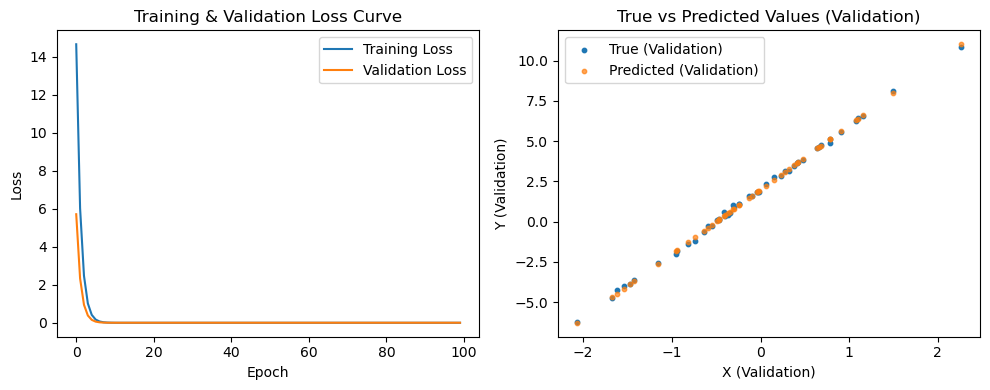


True W: 4.0, Learned W: 3.9915, Difference: -0.0085
True Bias: 2.0, Learned Bias: 1.9902, Difference: -0.0098


In [ ]:
np.random.seed(0)
X_all = np.random.randn(250, 1)  #  200 for train, 50 for val
true_W = np.array([[4.0]])
true_b = 2.0 # True bias
y_all = X_all @ true_W + true_b + np.random.randn(250, 1) * 0.1

# Split data into training and validation sets
split_ratio = 0.8
split_index = int(X_all.shape[0] * split_ratio)

X_train, y_train = X_all[:split_index], y_all[:split_index]
X_val, y_val = X_all[split_index:], y_all[split_index:]

print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

#####################################################################################################################

batch_size = 10
epochs = 100
learning_rate = 0.01

model = Linear(1, 1)
loss_fn = MSELoss()
train_losses = []
val_losses = [] 

#####################################################################################################################
for epoch in range(epochs):

    epoch_train_loss = 0
    for i in range(0, X_train.shape[0], batch_size):
        
        model.zero_grad() 

        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]

        yhat = model.forward(batch_X)
        loss_values = loss_fn.forward(batch_y, yhat) # Per-sample losses
        mean_batch_loss = np.mean(loss_values)       # Scalar loss for the batch
        
        delta = loss_fn.backward(batch_y, yhat)
        model.backward_update_gradient(batch_X, delta)
        # model.backward_delta(batch_X, delta) # Optional for this single-layer test
        model.update_parameters(learning_rate)
        
        epoch_train_loss += mean_batch_loss
    
    avg_epoch_train_loss = epoch_train_loss / (X_train.shape[0] // batch_size)
    train_losses.append(avg_epoch_train_loss)


    model.zero_grad() # Not strictly necessary if forward pass doesn't alter gradients
                      # and backward pass isn't called for validation.
    y_val_pred = model.forward(X_val)
    val_loss_values = loss_fn.forward(y_val, y_val_pred)
    avg_val_loss = np.mean(val_loss_values)
    val_losses.append(avg_val_loss)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {avg_epoch_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")


#####################################################################################################################

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1) 
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()

#####################################################################################################################

plt.subplot(1, 2, 2)
y_final_pred_val = model.forward(X_val) # Predict on validation data
plt.scatter(X_val, y_val, label="True (Validation)", s=10) 
plt.scatter(X_val, y_final_pred_val, label="Predicted (Validation)", alpha=0.7, s=10)

plt.xlabel("X (Validation)")
plt.ylabel("Y (Validation)")
plt.legend()
plt.title("True vs Predicted Values (Validation)")
plt.tight_layout()
plt.show()

#####################################################################################################################
learned_W = model._parameters["W"].flatten()[0] 
learned_b = model._parameters["b"].flatten()[0] 
print(f"\nTrue W: {true_W.flatten()[0]}, Learned W: {learned_W:.4f}, Difference: {learned_W - true_W.flatten()[0]:.4f}")
print(f"True Bias: {true_b}, Learned Bias: {learned_b:.4f}, Difference: {learned_b - true_b:.4f}")

- We can see that our parameters converges to the true values.
- Over 100 epochs our training loss fell from ~14.6 down to ~0.009, showing that gradient updates are correctly pushing our weights toward the optimum.
- After epoch 10, the training loss (0.011141 -> 0.009097) and validation loss (0.012375 -> 0.012667) drop dramatically and then quickly settle into a very stable, low value. The validation loss even slightly increases after epoch 10 and then stabilizes. This is typical behavior from a neural network.

# MNIST dataset 

In [42]:
from tensorflow.keras.datasets import mnist

# (60 000 train, 10 000 test)
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#  Normalize pixel values to [0,1] 
X_train = X_train.astype(np.float32) / 255.0
X_test  = X_test.astype(np.float32) / 255.0

# Flatten each 28×28 image to a 784-vector
X_train = X_train.reshape(-1, 28*28)
X_test  = X_test .reshape(-1, 28*28)

#  One-hot encode the integer labels into 10-dim vectors
def one_hot(y, num_classes=10):
    eye = np.eye(num_classes, dtype=np.float32)
    return eye[y]
y_train_oh = one_hot(y_train)
y_test_oh  = one_hot(y_test)

#  a tiny network for classification: 
#    [784 → 128 → TanH → 10 → Softmax]
net = Sequentiel()
net.add_module(Linear(784, 128))
net.add_module(TanH())
net.add_module(Linear(128, 10))
net.add_module(Softmax())

# Choose your loss and optimizer wrapper
loss_fn = CrossEntropyLoss()
opt = Optim(net, loss_fn, eps=0.001)

# Train for a few epochs on the training set
SGD(opt, X_train, y_train_oh, batch_size=64, epochs=100, verbose=True)

# Evaluate on the test set
yhat_test = net.forward(X_test)
preds = np.argmax(yhat_test, axis=1)
acc = (preds == y_test).mean()
print(f"Test accuracy: {acc * 100:.2f}%")


Epoch 0 LR: 0.001, Epoch Loss: 0.466184
Epoch 10 LR: 0.001, Epoch Loss: 0.098886
Epoch 20 LR: 0.001, Epoch Loss: 0.055032
Epoch 30 LR: 0.001, Epoch Loss: 0.034674
Epoch 40 LR: 0.001, Epoch Loss: 0.023103
Epoch 50 LR: 0.001, Epoch Loss: 0.016015
Epoch 60 LR: 0.001, Epoch Loss: 0.011601
Epoch 70 LR: 0.001, Epoch Loss: 0.008822
Epoch 80 LR: 0.001, Epoch Loss: 0.006970
Epoch 90 LR: 0.001, Epoch Loss: 0.005640
Epoch 99 LR: 0.001, Epoch Loss: 0.004797
Test accuracy: 97.81%


### Testing with non linear data (with different learning rates)


--- Training with Lr  0.1 ---
Epoch 0 LR: 0.1, Epoch Loss: 0.598668
Epoch 100 LR: 0.1, Epoch Loss: 0.118927
Epoch 200 LR: 0.1, Epoch Loss: 0.092445
Epoch 300 LR: 0.1, Epoch Loss: 0.100577
Epoch 400 LR: 0.1, Epoch Loss: 0.078172
Epoch 500 LR: 0.1, Epoch Loss: 0.009796
Epoch 600 LR: 0.1, Epoch Loss: 0.008498
Epoch 700 LR: 0.1, Epoch Loss: 0.005665
Epoch 800 LR: 0.1, Epoch Loss: 0.006556
Epoch 900 LR: 0.1, Epoch Loss: 0.005560
Epoch 999 LR: 0.1, Epoch Loss: 0.010200
  Completed SGD for LR 0.1. Final Epoch Loss: 0.010200

--- Training with Lr  0.05 ---
Epoch 0 LR: 0.05, Epoch Loss: 0.599466
Epoch 100 LR: 0.05, Epoch Loss: 0.297988
Epoch 200 LR: 0.05, Epoch Loss: 0.123569
Epoch 300 LR: 0.05, Epoch Loss: 0.105801
Epoch 400 LR: 0.05, Epoch Loss: 0.093751
Epoch 500 LR: 0.05, Epoch Loss: 0.096637
Epoch 600 LR: 0.05, Epoch Loss: 0.089310
Epoch 700 LR: 0.05, Epoch Loss: 0.088825
Epoch 800 LR: 0.05, Epoch Loss: 0.042853
Epoch 900 LR: 0.05, Epoch Loss: 0.010943
Epoch 999 LR: 0.05, Epoch Loss: 0.00

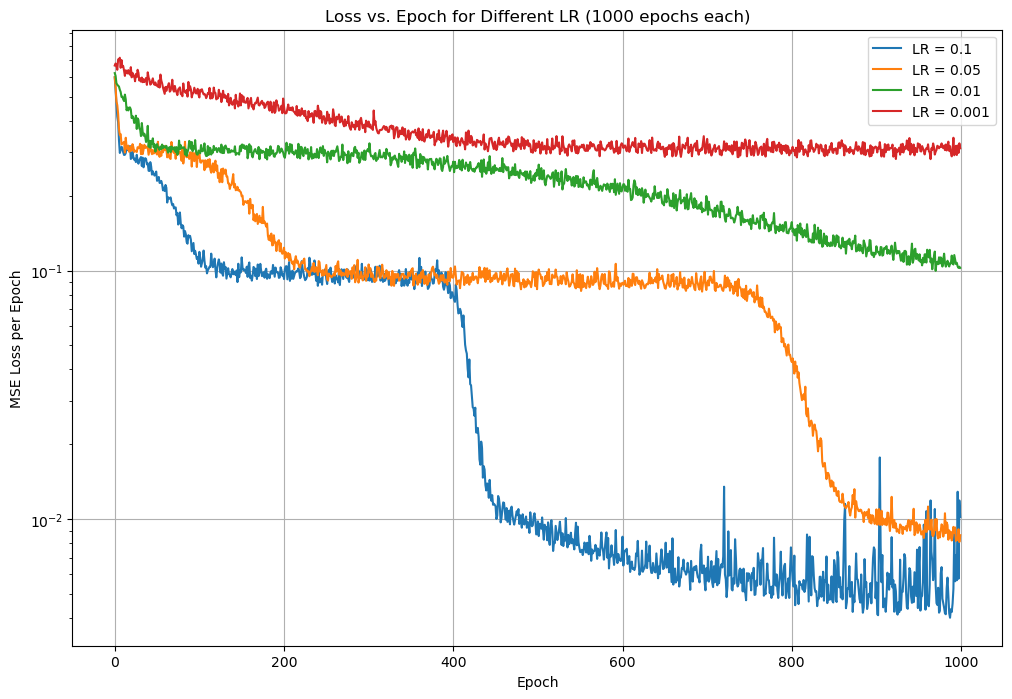

In [ ]:
np.random.seed(42) # Ensure reproducibility for the experiment
X_nl = np.random.rand(200, 2) * 2 - 1
y_nl_reg = (np.sin(X_nl[:, 0] * np.pi) + X_nl[:, 1]**2).reshape(-1, 1)
loss_fn_nl = MSELoss()


learning_rates_to_test = [0.1, 0.05, 0.01, 0.001]
num_epochs_per_lr = 1000 
batch_size_sgd = 32     

plt.figure(figsize=(12, 8))

for lr_val in learning_rates_to_test:
    print(f"\n--- Training with Lr  {lr_val} ---")
    
    model_nl_sgd = Sequentiel()
    model_nl_sgd.add_module(Linear(X_nl.shape[1], 10))
    model_nl_sgd.add_module(TanH())
    model_nl_sgd.add_module(Linear(10, 1))

    optimizer_sgd = Optim(model_nl_sgd, loss_fn_nl, eps=lr_val)


    losses_for_current_lr = SGD(optimizer_sgd, X_nl, y_nl_reg, 
                                batch_size=batch_size_sgd, 
                                epochs=num_epochs_per_lr, 
                                verbose=True) 

    final_loss_for_lr = losses_for_current_lr[-1] if losses_for_current_lr else float('nan')
    print(f"  Completed SGD for LR {lr_val}. Final Epoch Loss: {final_loss_for_lr:.6f}")

    plt.plot(losses_for_current_lr, label=f"LR = {lr_val}")

plt.title(f"Loss vs. Epoch for Different LR ({num_epochs_per_lr} epochs each)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss per Epoch")
plt.legend()
plt.grid(True)
# log scale for better visibility
plt.yscale('log')
plt.show()

### To test all the different module we created with a moon test I will test different set up combinations

In [ ]:
# preparing a one-hot encoding function and the data

def make_moons(n_samples=100, noise=0.2, random_state=None):
    if random_state: np.random.seed(random_state)
    n_samples_out = n_samples // 2
    n_samples_in = n_samples - n_samples_out
    outer_circ_x = np.cos(np.linspace(0, np.pi, n_samples_out))
    outer_circ_y = np.sin(np.linspace(0, np.pi, n_samples_out))
    inner_circ_x = 1 - np.cos(np.linspace(0, np.pi, n_samples_in))
    inner_circ_y = 1 - np.sin(np.linspace(0, np.pi, n_samples_in)) - .5
    X = np.vstack([np.append(outer_circ_x, inner_circ_x),
                   np.append(outer_circ_y, inner_circ_y)]).T
    y_labels = np.hstack([np.zeros(n_samples_out, dtype=np.intp),
                          np.ones(n_samples_in, dtype=np.intp)])
    if noise is not None:
        X += np.random.normal(scale=noise, size=X.shape)
    return X, y_labels 

def one_hot_encode(y_labels, num_classes):
    eye = np.eye(num_classes, dtype=np.float32)
    return eye[y_labels]


### Setup 1: Sigmoid() with BCE() loss 

Total samples: 5000
Training samples: 3000
Validation samples: 1000
Test samples: 1000

--- Training Moons with Sigmoid Output and BCE Loss ---
Starting SGD with LR=0.05 for 300 epochs...
  Epoch 1, Train Loss: 0.6731, Val Loss: 0.6453, Val Acc: 74.80%
  Epoch 30, Train Loss: 0.4155, Val Loss: 0.4326, Val Acc: 79.90%
  Epoch 60, Train Loss: 0.4159, Val Loss: 0.4314, Val Acc: 79.80%
  Epoch 90, Train Loss: 0.3951, Val Loss: 0.4125, Val Acc: 81.20%
  Epoch 120, Train Loss: 0.3841, Val Loss: 0.4132, Val Acc: 81.50%
  Epoch 150, Train Loss: 0.3866, Val Loss: 0.4005, Val Acc: 82.70%
  Epoch 180, Train Loss: 0.3839, Val Loss: 0.4032, Val Acc: 82.50%
  Epoch 210, Train Loss: 0.3851, Val Loss: 0.4013, Val Acc: 82.70%
  Epoch 240, Train Loss: 0.3856, Val Loss: 0.4007, Val Acc: 82.80%
  Epoch 270, Train Loss: 0.3848, Val Loss: 0.4030, Val Acc: 82.70%
  Epoch 300, Train Loss: 0.3844, Val Loss: 0.4018, Val Acc: 82.60%

--- Final Evaluation on Test Set ---
Test Loss: 0.3838
Test Accuracy: 83.10%


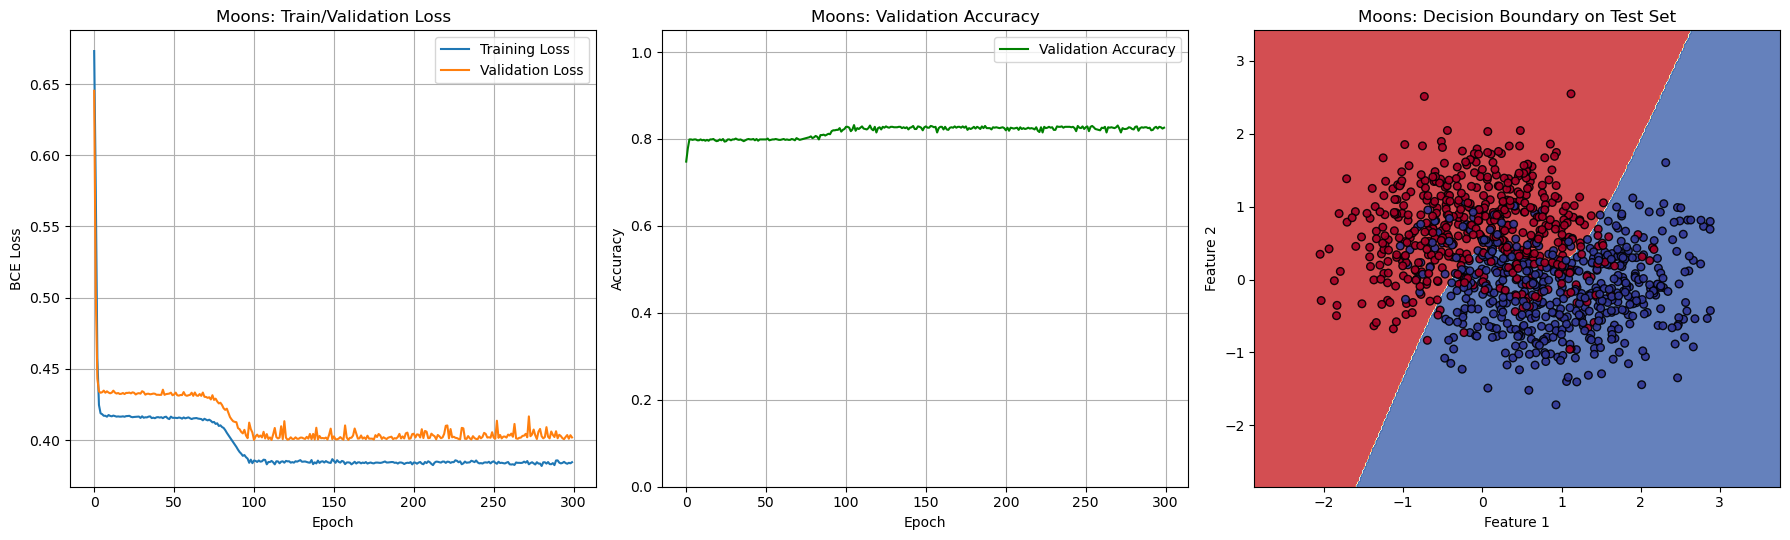

In [61]:

total_samples = 5000
X_all_moons, y_all_moons_labels = make_moons(n_samples=total_samples, noise=0.5, random_state=42)


permutation = np.random.permutation(total_samples)
X_all_moons = X_all_moons[permutation]
y_all_moons_labels = y_all_moons_labels[permutation]

train_end_idx = int(total_samples * 0.6)
val_end_idx = int(total_samples * 0.8) # 60% train, 20% val, 20% test

X_train_moons = X_all_moons[:train_end_idx]
y_train_moons_labels_flat = y_all_moons_labels[:train_end_idx]

X_val_moons = X_all_moons[train_end_idx:val_end_idx]
y_val_moons_labels_flat = y_all_moons_labels[train_end_idx:val_end_idx]

X_test_moons = X_all_moons[val_end_idx:]
y_test_moons_labels_flat = y_all_moons_labels[val_end_idx:]

print(f"Total samples: {total_samples}")
print(f"Training samples: {X_train_moons.shape[0]}")
print(f"Validation samples: {X_val_moons.shape[0]}")
print(f"Test samples: {X_test_moons.shape[0]}")


y_train_moons_binary = y_train_moons_labels_flat.reshape(-1, 1)
y_val_moons_binary = y_val_moons_labels_flat.reshape(-1, 1)
y_test_moons_binary = y_test_moons_labels_flat.reshape(-1, 1)


print("\n--- Training Moons with Sigmoid Output and BCE Loss ---")

input_features = X_train_moons.shape[1]
hidden_units = 20 
output_units_binary = 1

model_moons_clf = Sequentiel()
model_moons_clf.add_module(Linear(input_features, hidden_units))
model_moons_clf.add_module(TanH())
model_moons_clf.add_module(Linear(hidden_units, hidden_units // 2)) # Adding another small hidden layer
model_moons_clf.add_module(TanH())
model_moons_clf.add_module(Linear(hidden_units // 2, output_units_binary))
model_moons_clf.add_module(Sigmoid())

loss_fn_moons_clf = BCE()

learning_rate_clf = 0.05 
num_epochs_clf = 300    
batch_size_clf = 32

optimizer_clf = Optim(model_moons_clf, loss_fn_moons_clf, eps=learning_rate_clf)

train_epoch_losses = []
val_epoch_losses = []
val_epoch_accuracies = []

print(f"Starting SGD with LR={learning_rate_clf} for {num_epochs_clf} epochs...")
for epoch in range(num_epochs_clf):
    model_moons_clf.zero_grad() 
    
    # Shuffle training data each epoch
    epoch_permutation = np.random.permutation(X_train_moons.shape[0])
    X_train_shuffled = X_train_moons[epoch_permutation]
    y_train_shuffled = y_train_moons_binary[epoch_permutation]
    
    current_epoch_batch_losses = []
    for i in range(0, X_train_moons.shape[0], batch_size_clf):
        batch_X = X_train_shuffled[i:i+batch_size_clf]
        batch_y = y_train_shuffled[i:i+batch_size_clf]
        loss_this_batch = optimizer_clf.step(batch_X, batch_y)
        current_epoch_batch_losses.append(loss_this_batch)
        
    avg_train_loss_this_epoch = np.mean(current_epoch_batch_losses)
    train_epoch_losses.append(avg_train_loss_this_epoch)

    # Validation Step 
    y_val_pred_probs = model_moons_clf.forward(X_val_moons)
    val_loss_values = loss_fn_moons_clf.forward(y_val_moons_binary, y_val_pred_probs)
    avg_val_loss_this_epoch = np.mean(val_loss_values)
    val_epoch_losses.append(avg_val_loss_this_epoch)

    val_preds_binary = (y_val_pred_probs > 0.5).astype(int)
    val_accuracy_this_epoch = np.mean(val_preds_binary == y_val_moons_binary)
    val_epoch_accuracies.append(val_accuracy_this_epoch)

    if epoch == 0 or (epoch + 1) % (num_epochs_clf // 10 if num_epochs_clf >= 10 else 1) == 0:
        print(f"  Epoch {epoch+1}, Train Loss: {avg_train_loss_this_epoch:.4f}, Val Loss: {avg_val_loss_this_epoch:.4f}, Val Acc: {val_accuracy_this_epoch:.2%}")

y_test_pred_probs = model_moons_clf.forward(X_test_moons)
test_loss_values = loss_fn_moons_clf.forward(y_test_moons_binary, y_test_pred_probs)
final_test_loss = np.mean(test_loss_values)

test_preds_binary = (y_test_pred_probs > 0.5).astype(int)
final_test_accuracy = np.mean(test_preds_binary == y_test_moons_binary)

print(f"\n--- Final Evaluation on Test Set ---")
print(f"Test Loss: {final_test_loss:.4f}")
print(f"Test Accuracy: {final_test_accuracy:.2%}")


plt.figure(figsize=(18, 5.5)) 

plt.subplot(1, 3, 1)
plt.plot(train_epoch_losses, label="Training Loss")
plt.plot(val_epoch_losses, label="Validation Loss")
plt.title("Moons: Train/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_epoch_accuracies, label="Validation Accuracy", color='green')
plt.title("Moons: Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05) 
plt.legend()
plt.grid(True)
plt.subplot(1, 3, 3)
x_min, x_max = X_all_moons[:, 0].min() - 0.5, X_all_moons[:, 0].max() + 0.5 
y_min, y_max = X_all_moons[:, 1].min() - 0.5, X_all_moons[:, 1].max() + 0.5
step_size = 0.02

xx, yy = np.meshgrid(np.arange(x_min, x_max, step_size),
                     np.arange(y_min, y_max, step_size))

mesh_points = np.c_[xx.ravel(), yy.ravel()]
Z_probs_mesh = model_moons_clf.forward(mesh_points)
Z_classes_mesh = (Z_probs_mesh > 0.5).astype(int)
Z_classes_mesh = Z_classes_mesh.reshape(xx.shape)

plt.contourf(xx, yy, Z_classes_mesh, cmap=plt.cm.RdYlBu, alpha=0.8)
plt.scatter(X_test_moons[:, 0], X_test_moons[:, 1], c=y_test_moons_labels_flat, 
            cmap=plt.cm.RdYlBu, edgecolors='k', s=30, alpha=0.9)

plt.title("Moons: Decision Boundary on Test Set")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.tight_layout()
plt.show()

### Setup 2: Softmax() with CrossEntropyLoss()

This treats the binary problem as a 2-class multi-class problem.


--- Setup 2: Softmax Output with CrossEntropyLoss ---
Total samples: 5000
Training samples: 3000
Validation samples: 1000
Test samples: 1000
  Epoch 1/300, Train Loss: 0.6849, Val Loss: 0.6703, Val Acc: 76.00%
  Epoch 30/300, Train Loss: 0.4153, Val Loss: 0.4324, Val Acc: 80.10%
  Epoch 60/300, Train Loss: 0.4161, Val Loss: 0.4320, Val Acc: 79.70%
  Epoch 90/300, Train Loss: 0.4155, Val Loss: 0.4330, Val Acc: 80.10%
  Epoch 120/300, Train Loss: 0.4152, Val Loss: 0.4333, Val Acc: 80.00%
  Epoch 150/300, Train Loss: 0.4083, Val Loss: 0.4230, Val Acc: 80.40%
  Epoch 180/300, Train Loss: 0.3837, Val Loss: 0.4024, Val Acc: 82.80%
  Epoch 210/300, Train Loss: 0.3846, Val Loss: 0.4009, Val Acc: 82.80%
  Epoch 240/300, Train Loss: 0.3851, Val Loss: 0.4006, Val Acc: 82.80%
  Epoch 270/300, Train Loss: 0.3843, Val Loss: 0.4022, Val Acc: 82.80%
  Epoch 300/300, Train Loss: 0.3840, Val Loss: 0.4018, Val Acc: 82.40%

--- Final Evaluation on Test Set (Setup 2: Softmax/CrossEntropy) ---
Test Loss: 0

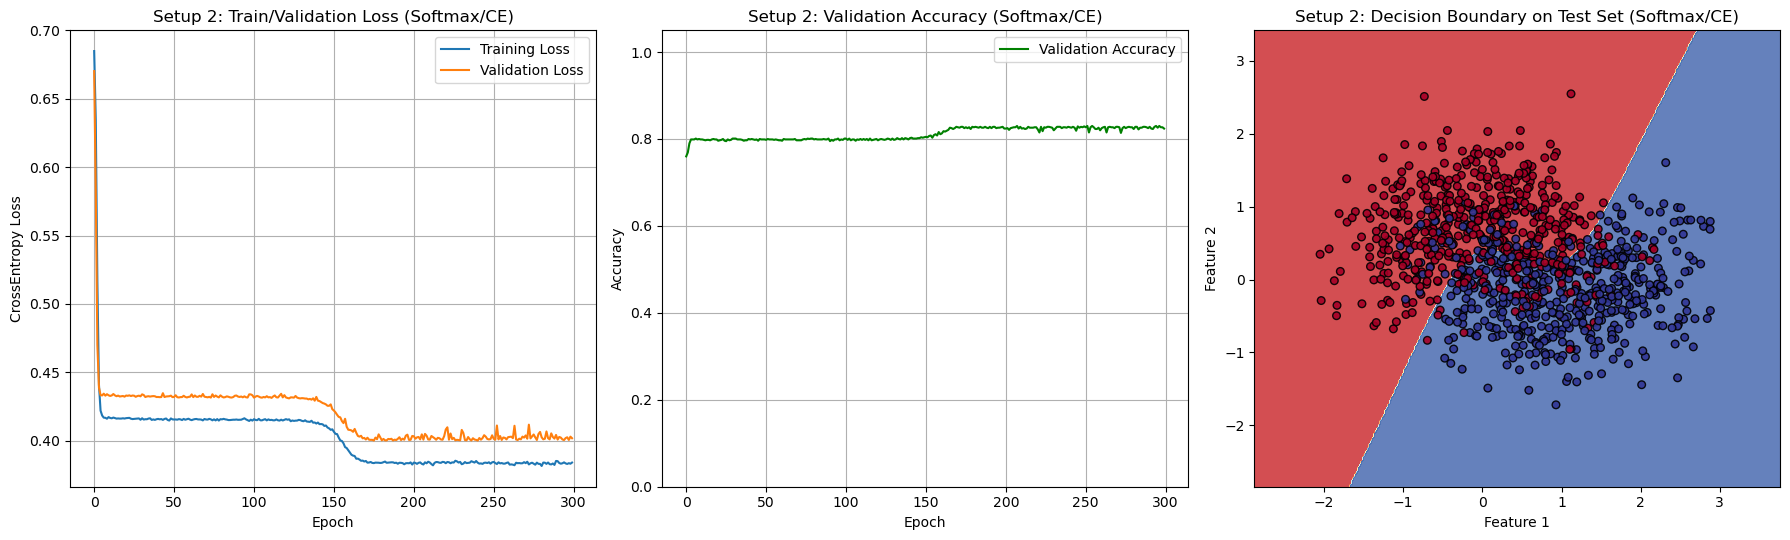

In [ ]:

total_samples_s2 = 5000
X_all_moons_s2, y_all_moons_labels_s2_flat = make_moons(n_samples=total_samples_s2, noise=0.5, random_state=42)
num_classes_s2 = 2 # We are treating binary as 2-class

permutation_s2 = np.random.permutation(total_samples_s2)
X_all_moons_s2 = X_all_moons_s2[permutation_s2]
y_all_moons_labels_s2_flat = y_all_moons_labels_s2_flat[permutation_s2]

train_end_idx_s2 = int(total_samples_s2 * 0.6)
val_end_idx_s2 = int(total_samples_s2 * 0.8)

X_train_moons_s2 = X_all_moons_s2[:train_end_idx_s2]
y_train_moons_labels_s2_flat = y_all_moons_labels_s2_flat[:train_end_idx_s2]

X_val_moons_s2 = X_all_moons_s2[train_end_idx_s2:val_end_idx_s2]
y_val_moons_labels_s2_flat = y_all_moons_labels_s2_flat[train_end_idx_s2:val_end_idx_s2]

X_test_moons_s2 = X_all_moons_s2[val_end_idx_s2:]
y_test_moons_labels_s2_flat = y_all_moons_labels_s2_flat[val_end_idx_s2:]

# One-hot encode labels for CrossEntropyLoss
y_train_moons_s2_oh = one_hot_encode(y_train_moons_labels_s2_flat, num_classes_s2)
y_val_moons_s2_oh = one_hot_encode(y_val_moons_labels_s2_flat, num_classes_s2)
y_test_moons_s2_oh = one_hot_encode(y_test_moons_labels_s2_flat, num_classes_s2)


print(f"\n--- Setup 2: Softmax Output with CrossEntropyLoss ---")
print(f"Total samples: {total_samples_s2}")
print(f"Training samples: {X_train_moons_s2.shape[0]}")
print(f"Validation samples: {X_val_moons_s2.shape[0]}")
print(f"Test samples: {X_test_moons_s2.shape[0]}")

input_features_s2 = X_train_moons_s2.shape[1]
hidden_units_s2 = 20

model_moons_s2 = Sequentiel()
model_moons_s2.add_module(Linear(input_features_s2, hidden_units_s2))
model_moons_s2.add_module(TanH())
model_moons_s2.add_module(Linear(hidden_units_s2, hidden_units_s2 // 2))
model_moons_s2.add_module(TanH())
model_moons_s2.add_module(Linear(hidden_units_s2 // 2, num_classes_s2)) # Output 2 units
model_moons_s2.add_module(Softmax())                                  # Softmax activation

loss_fn_moons_s2 = CrossEntropyLoss()

learning_rate_s2 = 0.001 
num_epochs_s2 = 300
batch_size_s2 = 32

optimizer_s2 = Optim(model_moons_s2, loss_fn_moons_s2, eps=learning_rate_s2)

train_epoch_losses_s2 = []
val_epoch_losses_s2 = []
val_epoch_accuracies_s2 = []

for epoch in range(num_epochs_s2):
    epoch_permutation_s2 = np.random.permutation(X_train_moons_s2.shape[0])
    X_train_shuffled_s2 = X_train_moons_s2[epoch_permutation_s2]
    y_train_shuffled_s2_oh = y_train_moons_s2_oh[epoch_permutation_s2] # Use one-hot labels
    
    current_epoch_batch_losses_s2 = []
    for i in range(0, X_train_moons_s2.shape[0], batch_size_s2):
        batch_X = X_train_shuffled_s2[i:i+batch_size_s2]
        batch_y_oh = y_train_shuffled_s2_oh[i:i+batch_size_s2] 
        
        loss_this_batch = optimizer_s2.step(batch_X, batch_y_oh) 
        current_epoch_batch_losses_s2.append(loss_this_batch)
        
    avg_train_loss_this_epoch_s2 = np.mean(current_epoch_batch_losses_s2)
    train_epoch_losses_s2.append(avg_train_loss_this_epoch_s2)

    # Validation Step
    y_val_pred_probs_s2 = model_moons_s2.forward(X_val_moons_s2) 
    val_loss_values_s2 = loss_fn_moons_s2.forward(y_val_moons_s2_oh, y_val_pred_probs_s2) 
    avg_val_loss_this_epoch_s2 = np.mean(val_loss_values_s2)
    val_epoch_losses_s2.append(avg_val_loss_this_epoch_s2)

    val_pred_labels_s2 = np.argmax(y_val_pred_probs_s2, axis=1) 
    val_accuracy_this_epoch_s2 = np.mean(val_pred_labels_s2 == y_val_moons_labels_s2_flat)
    val_epoch_accuracies_s2.append(val_accuracy_this_epoch_s2)

    if epoch == 0 or (epoch + 1) % (num_epochs_s2 // 10 if num_epochs_s2 >= 10 else 1) == 0:
        print(f"  Epoch {epoch+1}/{num_epochs_s2}, Train Loss: {avg_train_loss_this_epoch_s2:.4f}, Val Loss: {avg_val_loss_this_epoch_s2:.4f}, Val Acc: {val_accuracy_this_epoch_s2:.2%}")

y_test_pred_probs_s2 = model_moons_s2.forward(X_test_moons_s2)
test_loss_values_s2 = loss_fn_moons_s2.forward(y_test_moons_s2_oh, y_test_pred_probs_s2) 
final_test_loss_s2 = np.mean(test_loss_values_s2)

test_pred_labels_s2 = np.argmax(y_test_pred_probs_s2, axis=1) 
final_test_accuracy_s2 = np.mean(test_pred_labels_s2 == y_test_moons_labels_s2_flat) 

print(f"\n--- Final Evaluation on Test Set (Setup 2: Softmax/CrossEntropy) ---")
print(f"Test Loss: {final_test_loss_s2:.4f}")
print(f"Test Accuracy: {final_test_accuracy_s2:.2%}")


plt.figure(figsize=(18, 5.5))

plt.subplot(1, 3, 1)
plt.plot(train_epoch_losses_s2, label="Training Loss")
plt.plot(val_epoch_losses_s2, label="Validation Loss")
plt.title("Setup 2: Train/Validation Loss (Softmax/CE)")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_epoch_accuracies_s2, label="Validation Accuracy", color='green')
plt.title("Setup 2: Validation Accuracy (Softmax/CE)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
x_min_s2, x_max_s2 = X_all_moons_s2[:, 0].min() - 0.5, X_all_moons_s2[:, 0].max() + 0.5
y_min_s2, y_max_s2 = X_all_moons_s2[:, 1].min() - 0.5, X_all_moons_s2[:, 1].max() + 0.5
step_size_s2 = 0.02

xx_s2, yy_s2 = np.meshgrid(np.arange(x_min_s2, x_max_s2, step_size_s2),
                           np.arange(y_min_s2, y_max_s2, step_size_s2))

mesh_points_s2 = np.c_[xx_s2.ravel(), yy_s2.ravel()]
Z_probs_mesh_s2 = model_moons_s2.forward(mesh_points_s2) # Output shape (N_mesh, 2)
Z_classes_mesh_s2 = np.argmax(Z_probs_mesh_s2, axis=1)   # Get predicted class index
Z_classes_mesh_s2 = Z_classes_mesh_s2.reshape(xx_s2.shape)

plt.contourf(xx_s2, yy_s2, Z_classes_mesh_s2, cmap=plt.cm.RdYlBu, alpha=0.8)
plt.scatter(X_test_moons_s2[:, 0], X_test_moons_s2[:, 1], c=y_test_moons_labels_s2_flat,
            cmap=plt.cm.RdYlBu, edgecolors='k', s=30, alpha=0.9)

plt.title("Setup 2: Decision Boundary on Test Set (Softmax/CE)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.tight_layout()
plt.show()


--- Setup 3: LogSoftmax Output with NLLLoss ---
Total samples: 5000
Training samples: 3000
Validation samples: 1000
Test samples: 1000
Starting SGD with LR=0.001 for 300 epochs...
  Epoch 1/300, Train Loss: 0.6781, Val Loss: 0.6523, Val Acc: 79.20%
  Epoch 30/300, Train Loss: 0.4426, Val Loss: 0.4219, Val Acc: 80.60%
  Epoch 60/300, Train Loss: 0.4418, Val Loss: 0.4206, Val Acc: 81.10%
  Epoch 90/300, Train Loss: 0.4311, Val Loss: 0.4100, Val Acc: 82.00%
  Epoch 120/300, Train Loss: 0.4148, Val Loss: 0.3963, Val Acc: 81.60%
  Epoch 150/300, Train Loss: 0.4144, Val Loss: 0.3966, Val Acc: 81.60%
  Epoch 180/300, Train Loss: 0.4148, Val Loss: 0.3954, Val Acc: 81.90%
  Epoch 210/300, Train Loss: 0.4144, Val Loss: 0.3972, Val Acc: 81.70%
  Epoch 240/300, Train Loss: 0.4152, Val Loss: 0.3962, Val Acc: 81.80%
  Epoch 270/300, Train Loss: 0.4144, Val Loss: 0.3959, Val Acc: 81.90%
  Epoch 300/300, Train Loss: 0.4140, Val Loss: 0.3969, Val Acc: 81.80%

--- Final Evaluation on Test Set (Setup 3:

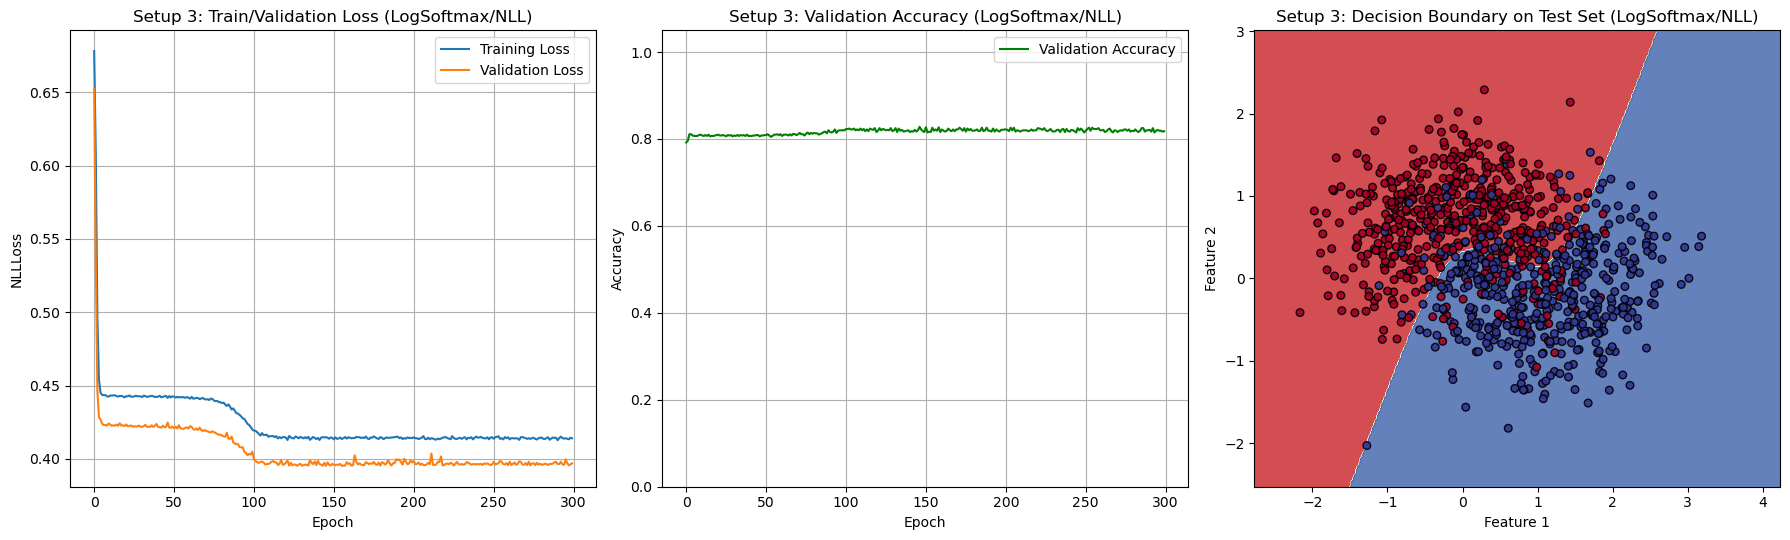

In [62]:
total_samples_s3 = 5000
X_all_moons_s3, y_all_moons_labels_s3_flat = make_moons(n_samples=total_samples_s3, noise=0.5, random_state=43) # Changed seed slightly for variety
num_classes_s3 = 2

permutation_s3 = np.random.permutation(total_samples_s3)
X_all_moons_s3 = X_all_moons_s3[permutation_s3]
y_all_moons_labels_s3_flat = y_all_moons_labels_s3_flat[permutation_s3]

train_end_idx_s3 = int(total_samples_s3 * 0.6)
val_end_idx_s3 = int(total_samples_s3 * 0.8)

X_train_moons_s3 = X_all_moons_s3[:train_end_idx_s3]
y_train_moons_labels_s3_flat = y_all_moons_labels_s3_flat[:train_end_idx_s3]

X_val_moons_s3 = X_all_moons_s3[train_end_idx_s3:val_end_idx_s3]
y_val_moons_labels_s3_flat = y_all_moons_labels_s3_flat[train_end_idx_s3:val_end_idx_s3]

X_test_moons_s3 = X_all_moons_s3[val_end_idx_s3:]
y_test_moons_labels_s3_flat = y_all_moons_labels_s3_flat[val_end_idx_s3:]

y_train_moons_s3_oh = one_hot_encode(y_train_moons_labels_s3_flat, num_classes_s3)
y_val_moons_s3_oh = one_hot_encode(y_val_moons_labels_s3_flat, num_classes_s3)
y_test_moons_s3_oh = one_hot_encode(y_test_moons_labels_s3_flat, num_classes_s3)


print(f"\n--- Setup 3: LogSoftmax Output with NLLLoss ---")
print(f"Total samples: {total_samples_s3}")
print(f"Training samples: {X_train_moons_s3.shape[0]}")
print(f"Validation samples: {X_val_moons_s3.shape[0]}")
print(f"Test samples: {X_test_moons_s3.shape[0]}")

input_features_s3 = X_train_moons_s3.shape[1]
hidden_units_s3 = 20 

model_moons_s3 = Sequentiel()
model_moons_s3.add_module(Linear(input_features_s3, hidden_units_s3))
model_moons_s3.add_module(TanH())
model_moons_s3.add_module(Linear(hidden_units_s3, hidden_units_s3 // 2))
model_moons_s3.add_module(TanH())
model_moons_s3.add_module(Linear(hidden_units_s3 // 2, num_classes_s3)) # Output 2 units
model_moons_s3.add_module(LogSoftmax())                                # LogSoftmax activation

loss_fn_moons_s3 = NLLLoss()

learning_rate_s3 = 0.001
num_epochs_s3 = 300
batch_size_s3 = 32

optimizer_s3 = Optim(model_moons_s3, loss_fn_moons_s3, eps=learning_rate_s3)

train_epoch_losses_s3 = []
val_epoch_losses_s3 = []
val_epoch_accuracies_s3 = []

print(f"Starting SGD with LR={learning_rate_s3} for {num_epochs_s3} epochs...")
for epoch in range(num_epochs_s3):
    epoch_permutation_s3 = np.random.permutation(X_train_moons_s3.shape[0])
    X_train_shuffled_s3 = X_train_moons_s3[epoch_permutation_s3]
    y_train_shuffled_s3_oh = y_train_moons_s3_oh[epoch_permutation_s3]
    
    current_epoch_batch_losses_s3 = []
    for i in range(0, X_train_moons_s3.shape[0], batch_size_s3):
        batch_X = X_train_shuffled_s3[i:i+batch_size_s3]
        batch_y_oh = y_train_shuffled_s3_oh[i:i+batch_size_s3]
        
        loss_this_batch = optimizer_s3.step(batch_X, batch_y_oh)
        current_epoch_batch_losses_s3.append(loss_this_batch)
        
    avg_train_loss_this_epoch_s3 = np.mean(current_epoch_batch_losses_s3)
    train_epoch_losses_s3.append(avg_train_loss_this_epoch_s3)

    # Validation Step
    y_val_pred_log_probs_s3 = model_moons_s3.forward(X_val_moons_s3) # Output shape (N_val, 2) - log probabilities
    val_loss_values_s3 = loss_fn_moons_s3.forward(y_val_moons_s3_oh, y_val_pred_log_probs_s3)
    avg_val_loss_this_epoch_s3 = np.mean(val_loss_values_s3)
    val_epoch_losses_s3.append(avg_val_loss_this_epoch_s3)

    val_pred_labels_s3 = np.argmax(y_val_pred_log_probs_s3, axis=1) # Get predicted class index from log_probs
    val_accuracy_this_epoch_s3 = np.mean(val_pred_labels_s3 == y_val_moons_labels_s3_flat)
    val_epoch_accuracies_s3.append(val_accuracy_this_epoch_s3)

    if epoch == 0 or (epoch + 1) % (num_epochs_s3 // 10 if num_epochs_s3 >= 10 else 1) == 0:
        print(f"  Epoch {epoch+1}/{num_epochs_s3}, Train Loss: {avg_train_loss_this_epoch_s3:.4f}, Val Loss: {avg_val_loss_this_epoch_s3:.4f}, Val Acc: {val_accuracy_this_epoch_s3:.2%}")

y_test_pred_log_probs_s3 = model_moons_s3.forward(X_test_moons_s3)
test_loss_values_s3 = loss_fn_moons_s3.forward(y_test_moons_s3_oh, y_test_pred_log_probs_s3)
final_test_loss_s3 = np.mean(test_loss_values_s3)

test_pred_labels_s3 = np.argmax(y_test_pred_log_probs_s3, axis=1)
final_test_accuracy_s3 = np.mean(test_pred_labels_s3 == y_test_moons_labels_s3_flat)

print(f"\n--- Final Evaluation on Test Set (Setup 3: LogSoftmax/NLLLoss) ---")
print(f"Test Loss: {final_test_loss_s3:.4f}")
print(f"Test Accuracy: {final_test_accuracy_s3:.2%}")


plt.figure(figsize=(18, 5.5))

plt.subplot(1, 3, 1)
plt.plot(train_epoch_losses_s3, label="Training Loss")
plt.plot(val_epoch_losses_s3, label="Validation Loss")
plt.title("Setup 3: Train/Validation Loss (LogSoftmax/NLL)")
plt.xlabel("Epoch")
plt.ylabel("NLLLoss")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(val_epoch_accuracies_s3, label="Validation Accuracy", color='green')
plt.title("Setup 3: Validation Accuracy (LogSoftmax/NLL)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
x_min_s3, x_max_s3 = X_all_moons_s3[:, 0].min() - 0.5, X_all_moons_s3[:, 0].max() + 0.5
y_min_s3, y_max_s3 = X_all_moons_s3[:, 1].min() - 0.5, X_all_moons_s3[:, 1].max() + 0.5
step_size_s3 = 0.02

xx_s3, yy_s3 = np.meshgrid(np.arange(x_min_s3, x_max_s3, step_size_s3),
                           np.arange(y_min_s3, y_max_s3, step_size_s3))

mesh_points_s3 = np.c_[xx_s3.ravel(), yy_s3.ravel()]
Z_log_probs_mesh_s3 = model_moons_s3.forward(mesh_points_s3) # Output shape (N_mesh, 2) - log_probs
Z_classes_mesh_s3 = np.argmax(Z_log_probs_mesh_s3, axis=1)   # Get predicted class index from log_probs
Z_classes_mesh_s3 = Z_classes_mesh_s3.reshape(xx_s3.shape)

plt.contourf(xx_s3, yy_s3, Z_classes_mesh_s3, cmap=plt.cm.RdYlBu, alpha=0.8)
plt.scatter(X_test_moons_s3[:, 0], X_test_moons_s3[:, 1], c=y_test_moons_labels_s3_flat,
            cmap=plt.cm.RdYlBu, edgecolors='k', s=30, alpha=0.9)

plt.title("Setup 3: Decision Boundary on Test Set (LogSoftmax/NLL)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

plt.tight_layout()
plt.show()

### Testing the Conv2D Module
Forward Pass Verification

In [ ]:
X_test_conv = np.arange(1*1*3*3).reshape(1, 1, 3, 3).astype(np.float32) 

conv_layer = Conv2D(input_channels=1, output_channels=1, kernel_size=2, stride=1, padding=0)
known_filter = np.array([[[[1, 0], [0, 1]]]]).astype(np.float32) # (1,1,2,2) output_c, input_c, kh, kw
known_bias = np.array([0.5]).astype(np.float32)
conv_layer._parameters["W"] = known_filter
conv_layer._parameters["b"] = known_bias

output_conv = conv_layer.forward(X_test_conv)
print("Input X:\n", X_test_conv)
print("Filter W:\n", known_filter)
print("Bias b:\n", known_bias)
print("Output conv:\n", output_conv)

expected_output_conv = np.array([[[[4.5, 6.5], [10.5, 12.5]]]])
assert np.allclose(output_conv, expected_output_conv), "Conv2D Forward Pass FAILED"
print("Conv2D Forward Pass with known weights: PASSED")

Input X:
 [[[[0. 1. 2.]
   [3. 4. 5.]
   [6. 7. 8.]]]]
Filter W:
 [[[[1. 0.]
   [0. 1.]]]]
Bias b:
 [0.5]
Output conv:
 [[[[ 4.5  6.5]
   [10.5 12.5]]]]
Conv2D Forward Pass with known weights: PASSED


Generated pattern data: X_patterns shape: (200, 1, 7, 7), y_patterns_oh shape: (200, 2)


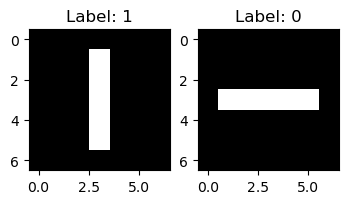

In [ ]:
# Helper function to generate simple image patterns
def generate_simple_patterns(num_samples_per_class=50, img_size=7):
    images = []
    labels = []
    # Class 0: Horizontal line
    for _ in range(num_samples_per_class):
        img = np.zeros((img_size, img_size), dtype=np.float32)
        center_row = img_size // 2
        img[center_row, 1:-1] = 1.0 # Draw a horizontal line
        images.append(img)
        labels.append(0)
    # Class 1: Vertical line
    for _ in range(num_samples_per_class):
        img = np.zeros((img_size, img_size), dtype=np.float32)
        center_col = img_size // 2
        img[1:-1, center_col] = 1.0 # Draw a vertical line
        images.append(img)
        labels.append(1)
    
    # Add a channel dimension (grayscale, so 1 channel)
    # Reshape to (num_samples, channels, height, width)
    X = np.array(images)[:, np.newaxis, :, :]
    y = np.array(labels)
    
    # Shuffle the data
    permutation = np.random.permutation(len(X))
    X = X[permutation]
    y = y[permutation]
    
    return X, y


img_s = 7 
X_patterns, y_patterns_labels = generate_simple_patterns(num_samples_per_class=100, img_size=img_s)
y_patterns_oh = one_hot_encode(y_patterns_labels, num_classes=2) # One-hot encode for CrossEntropyLoss

print(f"Generated pattern data: X_patterns shape: {X_patterns.shape}, y_patterns_oh shape: {y_patterns_oh.shape}")

# Optional: Visualize a couple of samples
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.imshow(X_patterns[0,0], cmap='gray')
plt.title(f"Label: {y_patterns_labels[0]}")
plt.subplot(1,2,2)
plt.imshow(X_patterns[-1,0], cmap='gray')
plt.title(f"Label: {y_patterns_labels[-1]}")
plt.show()

### Defining a Simple CNN Architecture

CNN Model defined.
LR: 0.01, Epochs: 100, Batch Size: 10
Epoch 0 LR: 0.01, Epoch Loss: 0.406907
Epoch 10 LR: 0.01, Epoch Loss: 0.001902
Epoch 20 LR: 0.01, Epoch Loss: 0.000837
Epoch 30 LR: 0.01, Epoch Loss: 0.000525
Epoch 40 LR: 0.01, Epoch Loss: 0.000379
Epoch 50 LR: 0.01, Epoch Loss: 0.000295
Epoch 60 LR: 0.01, Epoch Loss: 0.000240
Epoch 70 LR: 0.01, Epoch Loss: 0.000203
Epoch 80 LR: 0.01, Epoch Loss: 0.000175
Epoch 90 LR: 0.01, Epoch Loss: 0.000153
Epoch 99 LR: 0.01, Epoch Loss: 0.000138
Training finished.


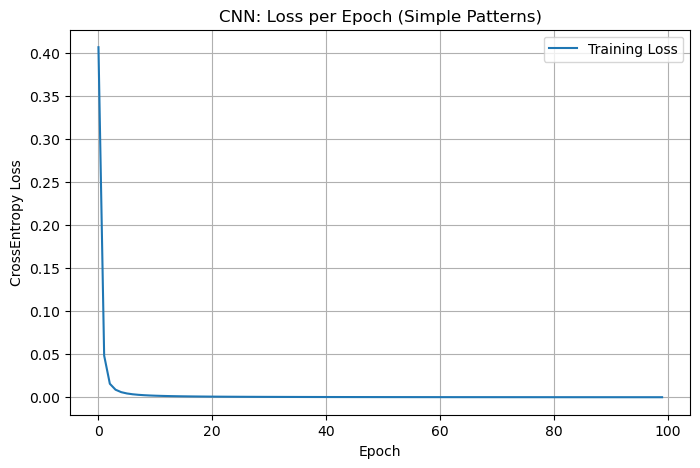


--- Final Evaluation on Pattern Data ---
Final Training Loss: 0.0001
Training Accuracy: 100.00%


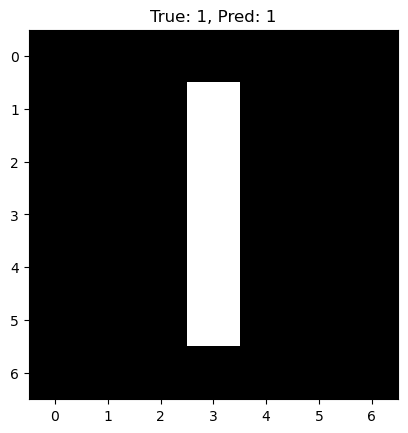

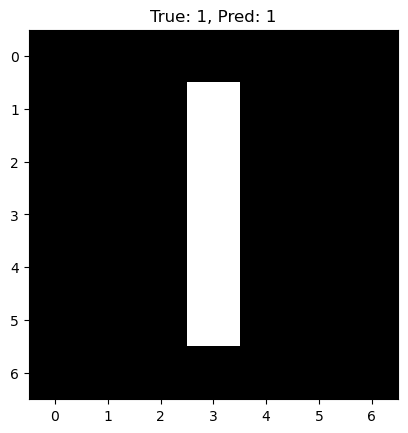

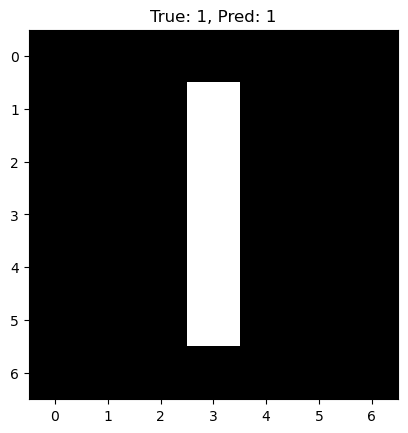

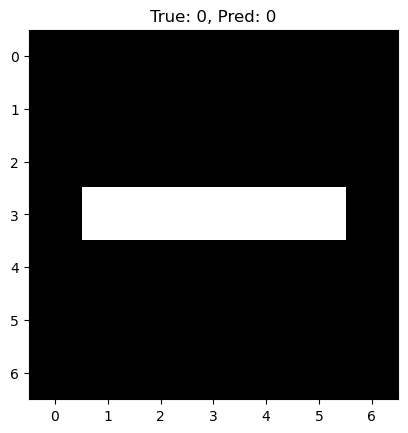

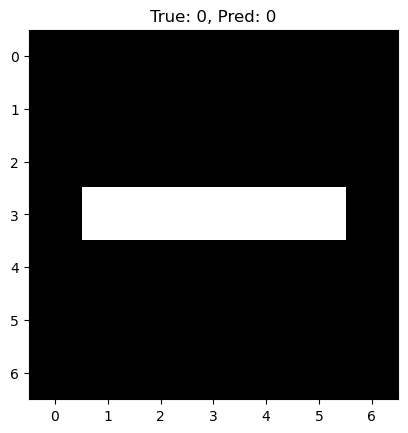

In [71]:
input_channels_exp = X_patterns.shape[1] 
num_output_classes_exp = y_patterns_oh.shape[1]

cnn_model = Sequentiel()
cnn_model.add_module(Conv2D(input_channels=input_channels_exp, output_channels=4, kernel_size=3, stride=1, padding=1))
cnn_model.add_module(TanH())

cnn_model.add_module(Flatten()) # Output shape: (N, 4*7*7) = (N, 196)

# The input size to this Linear layer must match the flattened output size from Conv2D/Flatten
flattened_size = 4 * img_s * img_s # Assuming padding maintains size
cnn_model.add_module(Linear(flattened_size, 32)) # 32 hidden units
cnn_model.add_module(TanH())

cnn_model.add_module(Linear(32, num_output_classes_exp))
cnn_model.add_module(Softmax()) 

print("CNN Model defined.")



loss_fn_cnn = CrossEntropyLoss() # Appropriate for Softmax output
learning_rate_cnn = 0.01       
num_epochs_cnn = 100          
batch_size_cnn = 10

optimizer_cnn = Optim(cnn_model, loss_fn_cnn, eps=learning_rate_cnn)

print(f"LR: {learning_rate_cnn}, Epochs: {num_epochs_cnn}, Batch Size: {batch_size_cnn}")


epoch_losses_cnn = SGD(optimizer_cnn, X_patterns, y_patterns_oh,
                       batch_size=batch_size_cnn,
                       epochs=num_epochs_cnn,
                       verbose=True)

print("Training finished.")

plt.figure(figsize=(8, 5))
plt.plot(epoch_losses_cnn, label="Training Loss")
plt.title("CNN: Loss per Epoch (Simple Patterns)")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.grid(True)
plt.show()


# Evaluation
y_pred_probs_cnn = cnn_model.forward(X_patterns)
pred_labels_cnn = np.argmax(y_pred_probs_cnn, axis=1)
accuracy_cnn = np.mean(pred_labels_cnn == y_patterns_labels)

final_loss_cnn = epoch_losses_cnn[-1] if epoch_losses_cnn else float('nan')

print(f"\n--- Final Evaluation on Pattern Data ---")
print(f"Final Training Loss: {final_loss_cnn:.4f}")
print(f"Training Accuracy: {accuracy_cnn:.2%}")



# few predictions:
for i in range(min(5, X_patterns.shape[0])):
    plt.imshow(X_patterns[i,0], cmap='gray')
    plt.title(f"True: {y_patterns_labels[i]}, Pred: {pred_labels_cnn[i]}")
    plt.show()

### Testing Maxpool

Shape after Conv1: (4, 7, 7)
Shape after Pool1: (4, 3, 3)
Shape after Flatten: (36,)
LR: 0.02, Epochs: 50, Batch Size: 10
Epoch 0 LR: 0.02, Epoch Loss: 0.518226
Epoch 5 LR: 0.02, Epoch Loss: 0.002444
Epoch 10 LR: 0.02, Epoch Loss: 0.001049
Epoch 15 LR: 0.02, Epoch Loss: 0.000655
Epoch 20 LR: 0.02, Epoch Loss: 0.000472
Epoch 25 LR: 0.02, Epoch Loss: 0.000367
Epoch 30 LR: 0.02, Epoch Loss: 0.000299
Epoch 35 LR: 0.02, Epoch Loss: 0.000252
Epoch 40 LR: 0.02, Epoch Loss: 0.000218
Epoch 45 LR: 0.02, Epoch Loss: 0.000191
Epoch 49 LR: 0.02, Epoch Loss: 0.000174


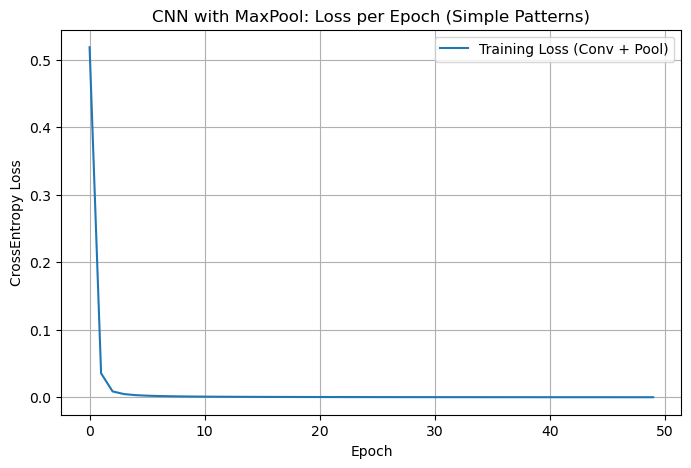


--- Final Evaluation on Pattern Data (CNN with MaxPool) ---
Final Training Loss: 0.0002
Training Accuracy: 100.00%


In [75]:
mg_s = 7 # Image size (e.g., 7x7)
X_patterns_pool, y_patterns_labels_pool = generate_simple_patterns(num_samples_per_class=150, img_size=img_s) # Slightly more data
y_patterns_pool_oh = one_hot_encode(y_patterns_labels_pool, num_classes=2)

input_channels_exp_pool = X_patterns_pool.shape[1] # 1
num_output_classes_exp_pool = y_patterns_pool_oh.shape[1] # 2

cnn_model_with_pool = Sequentiel()
conv1_out_channels = 4
conv1_kernel_size = 3
conv1_stride = 1
conv1_padding = 1 
cnn_model_with_pool.add_module(Conv2D(input_channels=input_channels_exp_pool,
                                      output_channels=conv1_out_channels,
                                      kernel_size=conv1_kernel_size,
                                      stride=conv1_stride,
                                      padding=conv1_padding))
h_after_conv1 = (img_s + 2*conv1_padding - conv1_kernel_size) // conv1_stride + 1
w_after_conv1 = (img_s + 2*conv1_padding - conv1_kernel_size) // conv1_stride + 1
print(f"Shape after Conv1: ({conv1_out_channels}, {h_after_conv1}, {w_after_conv1})")

cnn_model_with_pool.add_module(TanH())

pool1_kernel_size = 2
pool1_stride = 2
cnn_model_with_pool.add_module(MaxPool2D(kernel_size=pool1_kernel_size, stride=pool1_stride))
h_after_pool1 = (h_after_conv1 - pool1_kernel_size) // pool1_stride + 1
w_after_pool1 = (w_after_conv1 - pool1_kernel_size) // pool1_stride + 1
print(f"Shape after Pool1: ({conv1_out_channels}, {h_after_pool1}, {w_after_pool1})")


cnn_model_with_pool.add_module(Flatten())
flattened_size_pool = conv1_out_channels * h_after_pool1 * w_after_pool1
print(f"Shape after Flatten: ({flattened_size_pool},)")

hidden_fc_units = 20 
cnn_model_with_pool.add_module(Linear(flattened_size_pool, hidden_fc_units))
cnn_model_with_pool.add_module(TanH())

cnn_model_with_pool.add_module(Linear(hidden_fc_units, num_output_classes_exp_pool))
cnn_model_with_pool.add_module(Softmax())



loss_fn_cnn_pool = CrossEntropyLoss() 
learning_rate_cnn_pool = 0.02     
num_epochs_cnn_pool = 50         
batch_size_cnn_pool = 10

optimizer_cnn_pool = Optim(cnn_model_with_pool, loss_fn_cnn_pool, eps=learning_rate_cnn_pool)

print(f"LR: {learning_rate_cnn_pool}, Epochs: {num_epochs_cnn_pool}, Batch Size: {batch_size_cnn_pool}")

epoch_losses_cnn_pool = SGD(optimizer_cnn_pool, X_patterns_pool, y_patterns_pool_oh,
                            batch_size=batch_size_cnn_pool,
                            epochs=num_epochs_cnn_pool,
                            verbose=True)


plt.figure(figsize=(8, 5))
plt.plot(epoch_losses_cnn_pool, label="Training Loss (Conv + Pool)")
plt.title("CNN with MaxPool: Loss per Epoch (Simple Patterns)")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.grid(True)
plt.show()


y_pred_probs_cnn_pool = cnn_model_with_pool.forward(X_patterns_pool)
pred_labels_cnn_pool = np.argmax(y_pred_probs_cnn_pool, axis=1)
accuracy_cnn_pool = np.mean(pred_labels_cnn_pool == y_patterns_labels_pool)

final_loss_cnn_pool = epoch_losses_cnn_pool[-1] if epoch_losses_cnn_pool else float('nan')

print(f"\n--- Final Evaluation on Pattern Data (CNN with MaxPool) ---")
print(f"Final Training Loss: {final_loss_cnn_pool:.4f}")
print(f"Training Accuracy: {accuracy_cnn_pool:.2%}")


# Optional: Visualize a few predictions and their original images
# for i in range(min(5, X_patterns_pool.shape[0])):
#     plt.imshow(X_patterns_pool[i,0], cmap='gray')
#     plt.title(f"True: {y_patterns_labels_pool[i]}, Pred: {pred_labels_cnn_pool[i]}")
#     plt.show()

### Testing the auto encoder with MNIST

In [79]:
(X_train_mnist_ae_orig, y_train_mnist_ae_labels), (X_test_mnist_ae_orig, y_test_mnist_ae_labels) = mnist.load_data()

X_train_mnist_ae_norm = X_train_mnist_ae_orig.astype(np.float32) / 255.0
X_test_mnist_ae_norm = X_test_mnist_ae_orig.astype(np.float32) / 255.0

X_train_mnist_ae_flat = X_train_mnist_ae_norm.reshape(-1, 28*28)
X_test_mnist_ae_flat = X_test_mnist_ae_norm.reshape(-1, 28*28)

y_train_mnist_ae_target = X_train_mnist_ae_flat
y_test_mnist_ae_target = X_test_mnist_ae_flat # For evaluating reconstruction on test set

print(f"X_train_mnist_ae_flat shape: {X_train_mnist_ae_flat.shape}")
print(f"X_test_mnist_ae_flat shape: {X_test_mnist_ae_flat.shape}")

# smaller data set if needed 
# num_train_ae_subset = 5000
# num_test_ae_subset = 1000
# X_train_ae_subset = X_train_mnist_ae_flat[:num_train_ae_subset]
# y_train_ae_target_subset = y_train_mnist_ae_target[:num_train_ae_subset]
# X_test_ae_subset = X_test_mnist_ae_flat[:num_test_ae_subset]
# y_test_ae_target_subset = y_test_mnist_ae_target[:num_test_ae_subset]
# print(f"Using subset for AE: Train {X_train_ae_subset.shape[0]}, Test {X_test_ae_subset.shape[0]}")

X_train_mnist_ae_flat shape: (60000, 784)
X_test_mnist_ae_flat shape: (10000, 784)


In [80]:
#Defining Encoder and Decoder Architectures

input_dim_ae = X_train_mnist_ae_flat.shape[1]  # 784
latent_dim = 32  # Example: Size of the compressed representation 

# Encoder: Input (784) -> Hidden1 (128) -> Hidden2 (64) -> Latent (32)
encoder = Sequentiel()
encoder.add_module(Linear(input_dim_ae, 128))
encoder.add_module(TanH()) 
encoder.add_module(Linear(128, 64))
encoder.add_module(TanH())
encoder.add_module(Linear(64, latent_dim))

# Decoder: Latent (32) -> Hidden1 (64) -> Hidden2 (128) -> Output (784)
decoder = Sequentiel()
decoder.add_module(Linear(latent_dim, 64))
decoder.add_module(TanH())
decoder.add_module(Linear(64, 128))
decoder.add_module(TanH())
decoder.add_module(Linear(128, input_dim_ae))
decoder.add_module(Sigmoid()) # Sigmoid to ensure output is between 0 and 1, like normalized input pixels

autoencoder_model = AutoEncodeur(encoder, decoder)
print("Autoencoder model defined.")

Autoencoder model defined.



Starting Autoencoder training...
LR: 0.001, Epochs: 20, Batch Size: 128
Training on 60000 samples.
Epoch 0 LR: 0.001, Epoch Loss: 0.112254
Epoch 2 LR: 0.001, Epoch Loss: 0.068382
Epoch 4 LR: 0.001, Epoch Loss: 0.067746
Epoch 6 LR: 0.001, Epoch Loss: 0.067493
Epoch 8 LR: 0.001, Epoch Loss: 0.067061
Epoch 10 LR: 0.001, Epoch Loss: 0.065437
Epoch 12 LR: 0.001, Epoch Loss: 0.062771
Epoch 14 LR: 0.001, Epoch Loss: 0.060219
Epoch 16 LR: 0.001, Epoch Loss: 0.057892
Epoch 18 LR: 0.001, Epoch Loss: 0.055575
Epoch 19 LR: 0.001, Epoch Loss: 0.054417
Autoencoder training finished.


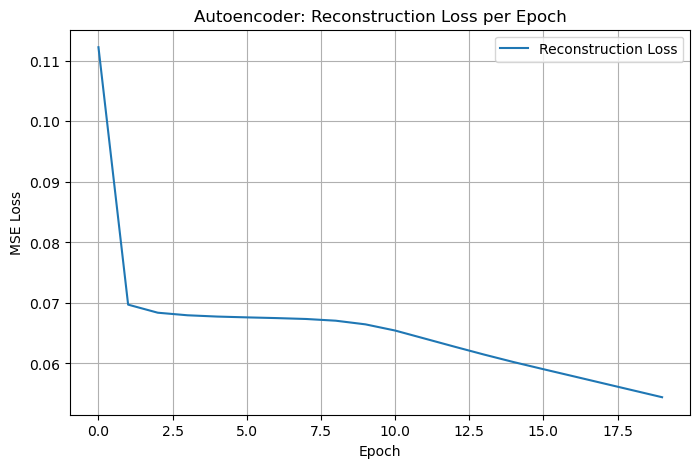

In [81]:
loss_fn_ae = MSELoss()
learning_rate_ae = 0.001 # Autoencoders can be sensitive; starting with a smaller LR
num_epochs_ae = 20      
batch_size_ae = 128

X_train_data = X_train_mnist_ae_flat 
y_train_target = y_train_mnist_ae_target

optimizer_ae = Optim(autoencoder_model, loss_fn_ae, eps=learning_rate_ae)

print(f"\nStarting Autoencoder training...")
print(f"LR: {learning_rate_ae}, Epochs: {num_epochs_ae}, Batch Size: {batch_size_ae}")
print(f"Training on {X_train_data.shape[0]} samples.")


epoch_losses_ae = SGD(optimizer_ae, 
                      X_train_data,       
                      y_train_target,    
                      batch_size=batch_size_ae,
                      epochs=num_epochs_ae,
                      verbose=True)

print("Autoencoder training finished.")

plt.figure(figsize=(8, 5))
plt.plot(epoch_losses_ae, label="Reconstruction Loss")
plt.title("Autoencoder: Reconstruction Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

Final Reconstruction MSE on evaluation data: 0.051763
Displaying original vs. reconstructed MNIST digits:


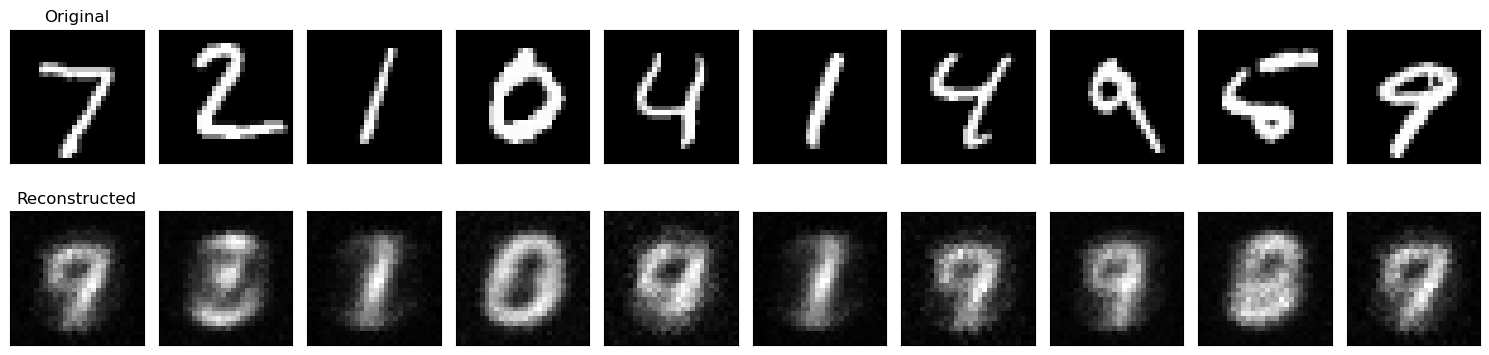

In [ ]:
#Evaluating Autoencoder Reconstructions


X_eval_data = X_test_mnist_ae_flat[:100] # Take first 100 test images for display

# Get reconstructions
reconstructed_images = autoencoder_model.forward(X_eval_data)

eval_loss_values = loss_fn_ae.forward(X_eval_data, reconstructed_images) # Target is original data
final_eval_loss = np.mean(eval_loss_values)
print(f"Final Reconstruction MSE on evaluation data: {final_eval_loss:.6f}")

# Visually compare original and reconstructed images
n_to_display = 10 # Number of digits to display
plt.figure(figsize=(15, 4)) 
print("Displaying original vs. reconstructed MNIST digits:")
for i in range(n_to_display):
    ax = plt.subplot(2, n_to_display, i + 1)
    plt.imshow(X_eval_data[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Original")

    ax = plt.subplot(2, n_to_display, i + 1 + n_to_display)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Reconstructed")
plt.tight_layout()
plt.show()



### 2D Latent Space of MNIST Digits

In [ ]:
encoder = autoencoder_model.encodeur 

latent_vectors = encoder.forward(X_test_mnist_ae_flat) # Shape (num_test_samples, 2)

# Plotting
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=y_test, cmap='viridis', s=5) # Use y_test for colors
plt.colorbar(scatter, label='Digit Label')
plt.title('2D Latent Space of MNIST Digits')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()
